# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1uAUJGEUzfNj6OsWNAimnYCw7eKaHhMUfU1MTj9YwYw4/edit?usp=sharing), [grading rubric](https://docs.google.com/document/d/1hKuRWqFcIdhOkow3Nljcm7PXzIkoa9c_aHkMKZDxWa0/edit?usp=sharing)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an outline to help you with your own approach.**_

## Project Setup

In [73]:
import math
import os
import numpy as np
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
from sqlalchemy import create_engine
import re
import datetime
import sqlite3
import scipy.stats as st

In [2]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "data/taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
UBER_CSV = ""
WEATHER_CSV_DIR = ""

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [3]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Calculate distance

In [4]:
def calculate_distance_with_coords(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    """
    This function calculate the distance for taxi data and uber data
    input: pickup longitude and latitude, dropoff longitude and latitude
    output: distance between the pickup location and dropoff location
    """
    
    lat1=pickup_longitude
    lon1=pickup_latitude
    lat2=dropoff_longitude
    lon2=dropoff_latitude
    
    R = 6371  # Earth's radius in kilometers

    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # calculate differences between latitudes and longitudes
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1

    # calculate Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c

    return distance

Add Distance Column

In [5]:
def add_distance_column(dataframe):
    """
    This function adds the distance column to the uber_data dataframe (use the function above)
    input: uber_data dataframe
    output: dataframe with distance column
    """
    dataframe['distance'] = dataframe.apply(lambda row: calculate_distance_with_coords(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    return dataframe

### Process Taxi Data

In [6]:
# Get the website page of the taxi_url
def get_taxi_html():
    """
    This function gets the website page of the taxi_url
    input: nothing
    output: content in the taxi website
    
    """
    response = requests.get(TAXI_URL)
    html = response.content
    return html

In [7]:
# In the website page, find links for 'Yellow Taxi Trip Records'
# From 2009 to 2015 monthly data
def find_taxi_parquet_links():
    """
    This function gets the links for 'Yellow Taxi Trip Records'
    input: nothing
    output: a list of links for the 'Yellow Taxi Trip Records',
    from 2009 to 2015 monthly data
    
    """
    get_taxi_html()
    soup = bs4.BeautifulSoup(get_taxi_html(), 'html.parser')
    l1 = soup.find_all("a")
    l2 = []
    l3 = []
    pattern = []
    for i in range(len(l1)):
        if l1[i].text == 'Yellow Taxi Trip Records':
            l2.append(l1[i]['href'])
    for j in range(len(l2)):
        pattern.append(r"2009-\d{2}")
        pattern.append(r"2010-\d{2}")
        pattern.append(r"2011-\d{2}")
        pattern.append(r"2012-\d{2}")
        pattern.append(r"2013-\d{2}")
        pattern.append(r"2014-\d{2}")
        pattern.append(r"2015-\d{2}")
        for i in range(7):
            if re.search(pattern[i], l2[j]):
                l3.append(l2[j])
                break
        
    return l3

In [8]:
# Get the taxi zones data, process the data to show the longitude and latitude for a given location ID
taxi_zones_df = gpd.read_file("taxi_zones/taxi_zones.shp")
taxi_zones_df = taxi_zones_df.to_crs(CRS)
taxi_zones_df['longitude'] = taxi_zones_df.centroid.x  
taxi_zones_df['latitude'] = taxi_zones_df.centroid.y

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/2095852162.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zones_df['longitude'] = taxi_zones_df.centroid.x
/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/2095852162.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zones_df['latitude'] = taxi_zones_df.centroid.y


In [9]:
# Given the url of the 'Yellow Taxi Trip Records', download the data, 
# Generate a sampling of Yellow Taxi data that’s roughly equal to the sample size of the Uber dataset
# Select useful columns and rename them
# Calculate duration of trip (trip end time - trip start time)
# If the dataset only have location ID, select rows with valid location ID
# change the location ID into longitude and latitude
# Remove the data that is not within the specified limits
# Change the measurement of duration to seconds, delete rows that have super long duration (outlier)
# Delete rows with negative duration
# Delete rows that have super long distance (outlier)
# Delete rows with negative distance
# Return the cleaned dataframe

def process_dataframe(url, taxi_zones_df):
    """
    This function download the data from the taxi website and process the data to a dataframe
    input: url of the 'Yellow Taxi Trip Records', taxi zones dataframe
    output: a processed dataframe
    
    """
    df = pd.read_parquet(url, engine='pyarrow')
    df = df.sample(frac =0.0002)
    if "tpep_pickup_datetime" not in df.columns:
        if "Trip_Pickup_DateTime" in df.columns:
            df = df[["Trip_Pickup_DateTime", "Trip_Dropoff_DateTime", "Start_Lon", "Start_Lat", "End_Lon", "End_Lat", "Tip_Amt"]]
            df.rename(columns = {'Start_Lon':'pickup_longitude', 'Start_Lat':'pickup_latitude',
                                  'End_Lon':'dropoff_longitude', 'End_Lat':'dropoff_latitude'}, inplace = True)

        elif "pickup_datetime" in df.columns:
            df = df[["pickup_datetime", "dropoff_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "tip_amount"]]
            df.rename(columns = {'pickup_datetime':'Trip_Pickup_DateTime', 'dropoff_datetime':'Trip_Dropoff_DateTime',
                                  'tip_amount':'Tip_Amt'}, inplace = True)  
        
        df['Trip_Pickup_DateTime'] = df['Trip_Pickup_DateTime'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        df['Trip_Dropoff_DateTime'] = df['Trip_Dropoff_DateTime'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        df['duration'] =  df['Trip_Dropoff_DateTime'] - df['Trip_Pickup_DateTime']
        
        
        
    else:
        df = df[["tpep_pickup_datetime", "tpep_dropoff_datetime", "PULocationID", "DOLocationID", "tip_amount"]]
        df = df[(df["PULocationID"] < 263) & (df["PULocationID"] > 0) 
               & (df["DOLocationID"] < 263) & (df["DOLocationID"] > 0)]
        df = df.merge(taxi_zones_df[['LocationID','longitude','latitude']].set_index('LocationID'),
                                    left_on='PULocationID', right_on='LocationID')
        df = df.rename(columns={'longitude': 'pickup_longitude', 'latitude': 'pickup_latitude'})
        df = df.merge(taxi_zones_df[['LocationID','longitude','latitude']].set_index('LocationID'),
                                    left_on='DOLocationID', right_on='LocationID')
        df = df.rename(columns={'longitude': 'dropoff_longitude', 'latitude': 'dropoff_latitude'})
        df = df.drop(columns=["PULocationID", "DOLocationID"])
        df = df.rename(columns={'tpep_pickup_datetime': 'Trip_Pickup_DateTime', 'tpep_dropoff_datetime': 'Trip_Dropoff_DateTime', 'tip_amount': 'Tip_Amt'})
        df['duration'] =  df['Trip_Dropoff_DateTime'] - df['Trip_Pickup_DateTime']
        

    westlimit=-74.242330; southlimit=40.560445; eastlimit=-73.717047; northlimit=40.908524
    df = df[(df['pickup_longitude']<eastlimit) & (df['pickup_longitude']>westlimit)
        & (df['pickup_latitude']<northlimit) & (df['pickup_latitude']>southlimit)
        & (df['dropoff_longitude']<eastlimit) & (df['dropoff_longitude']>westlimit)
        & (df['dropoff_latitude']<northlimit) & (df['dropoff_latitude']>southlimit)]
    df['duration'] = df['duration'].apply(lambda x:x/np.timedelta64(1, 's'))
    df = df[(df['duration'] <= 10000) & (df['duration'] > 0)]
    df['distance'] = df.apply(lambda row: calculate_distance_with_coords(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    df = df[(df['distance'] <= 100) & (df['distance'] > 0)]
    
    return df

In [10]:
# Getting the full dataset for taxi data
# Get dataframes from every month by function process_dataframe(url, taxi_zones_df) (defined above)
# concat them together by time order to make the full dataset

def get_full_data():
    """
    This function gets the full dataset for texi data (2009 to 2015)
    input: nothing
    output: a concat full dataset of all months taxi data
    
    """
    urls = find_taxi_parquet_links()
    df = process_dataframe(urls[72], taxi_zones_df)
    for i in range(73, 84):
        df1 = process_dataframe(urls[i], taxi_zones_df)
        df = pd.concat([df, df1])
    for i in range(60, 72):
        df1 = process_dataframe(urls[i], taxi_zones_df)
        df = pd.concat([df, df1])       
    for i in range(48, 60):
        df1 = process_dataframe(urls[i], taxi_zones_df)
        df = pd.concat([df, df1])
    for i in range(36, 48):
        df1 = process_dataframe(urls[i], taxi_zones_df)
        df = pd.concat([df, df1])    
    for i in range(24, 36):
        df1 = process_dataframe(urls[i], taxi_zones_df)
        df = pd.concat([df, df1])    
    for i in range(12, 24):
        df1 = process_dataframe(urls[i], taxi_zones_df)
        df = pd.concat([df, df1])    
    for i in range(0, 6):
        df1 = process_dataframe(urls[i], taxi_zones_df)
        df = pd.concat([df, df1])     
    return df

In [11]:
taxi_data = get_full_data()

In [12]:
taxi_data.head()

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Tip_Amt,duration,distance
119485,2009-01-22 08:46:06,2009-01-22 09:01:57,-73.955878,40.779544,-73.983201,40.750635,0.0,951.0,3.953261
5959553,2009-01-25 22:54:24,2009-01-25 23:04:54,-73.966458,40.764619,-73.902177,40.751212,0.0,630.0,5.615712
9048854,2009-01-01 01:04:40,2009-01-01 01:15:55,-74.007959,40.712268,-74.004304,40.733643,0.0,675.0,2.396666
7930704,2009-01-20 22:32:51,2009-01-20 22:38:04,-73.969588,40.757882,-73.983916,40.762663,0.0,313.0,1.318677
11257914,2009-01-11 02:25:52,2009-01-11 02:38:10,-74.008106,40.740507,-73.983748,40.762275,0.0,738.0,3.173123


### Processing Uber Data

In [13]:
def load_and_clean_uber_data(csv_file):
    """
    This function get to load and clean uber data, 
    this function drop the useless column, and remove trips outside of the zone
    input: the uber data csv file
    output: the cleaned uber data
    
    """
    data_1 = pd.read_csv(csv_file)
    data_2 = data_1.drop(columns=['Unnamed: 0','key','fare_amount','passenger_count'])
    data_3 = data_2.dropna()
    
    # Define the range of acceptable latitude and longitude values
    min_lat, max_lat = 40.560445, 40.908524
    min_long, max_long = -74.242330, -73.717047
    
    # Remove trips that start and/or end outside of the latitude/longitude coordinate box
    data_4 = data_3.drop(
    index=data_3[
    (data_3['pickup_latitude'] < min_lat) & 
    (data_3['pickup_latitude'] > max_lat) &
    (data_3['pickup_longitude'] < min_long) &
    (data_3['pickup_longitude'] > max_long) &
    (data_3['dropoff_latitude'] < min_lat) &
    (data_3['dropoff_latitude'] > max_lat) &
    (data_3['dropoff_longitude'] < min_long) &
    (data_3['dropoff_longitude'] > max_long)
    ].index
)
    
    #normalizing and using appropriate column types for the respective data
    data_4['pickup_datetime'] = pd.to_datetime(data_3['pickup_datetime'])
    data_4 = data_4.rename(columns = {'pickup_datetime': 'Trip_Pickup_DateTime'})
    
    return data_4

In [14]:
def get_uber_data():
    """
    This function add distance columns to the cleaned uber data set
    input: nothing
    output: new uber dataframe (with distance column)
    """
    uber_dataframe = load_and_clean_uber_data(UBER_DATA)
    add_distance_column(uber_dataframe)
    return uber_dataframe

In [15]:
UBER_DATA = "uber_rides_sample.csv"

In [16]:
uber_data = get_uber_data()


In [17]:
uber_data=uber_data[uber_data['distance']<100]

In [18]:
uber_data.head()

,Trip_Pickup_DateTime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.683323
1,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,2.457590
2,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,5.036377
3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,1.661683
4,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,4.475450


### Processing Weather Data

In [19]:
def clean_month_weather_data_hourly(csv_file):
    """
    This function is to get clean hourly weather data, select only the requred columns,
    convert required columns to numeric datatype, and fill nan values with 0
    input: the raw weather data (all of the data are csv files)
    output: cleaned hourly weather data
    
    """
    weather_data=pd.read_csv(csv_file)
    weather_data['REPORT_TYPE'] = weather_data['REPORT_TYPE'].astype(str)
    weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])
    
    # Filter out the rows where 'REPORT_TYPE' column contains the string 'SOD'
    hourly_data = weather_data.loc[~weather_data['REPORT_TYPE'].str.contains('SOD')]

    # Select only the required columns and rename them
    hourly_data = hourly_data[['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed']]
    hourly_data = hourly_data.rename(columns={'DATE': 'datetime', 'HourlyPrecipitation': 'hourly_precipitation', 'HourlyWindSpeed': 'hourly_wind_speed'})

    # Convert 'HourlyPrecipitation' and 'HourlyWindSpeed' columns to numeric datatype
    hourly_data[['hourly_precipitation', 'hourly_wind_speed']] = hourly_data[['hourly_precipitation', 'hourly_wind_speed']].apply(pd.to_numeric, errors='coerce')

    # Fill NaN values in 'HourlyPrecipitation' and 'HourlyWindSpeed' columns with 0
    hourly_data[['hourly_precipitation', 'hourly_wind_speed']] = hourly_data[['hourly_precipitation', 'hourly_wind_speed']].fillna(0)
    
    return hourly_data

In [20]:
def clean_month_weather_data_daily(csv_file):  
    """
    This function is to get clean daily weather data, select only the requred columns,
    convert required columns to numeric datatype, and fill nan values with 0
    input: the raw weather data (all of the data are csv files)
    output: cleaned daily weather data
    
    """
    weather_data = pd.read_csv(csv_file)
    weather_data['DATE'] = pd.to_datetime(weather_data['DATE']).dt.date
    
     # Filter out the rows where 'REPORT_TYPE' column contains the string 'SOD'
    hourly_data = weather_data.loc[~weather_data['REPORT_TYPE'].str.contains('SOD')]

    # Select only the required columns
    hourly_data = hourly_data[['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed']]
    
    # Convert the 'HourlyPrecipitation' and 'HourlyWindSpeed' columns to numeric format
    hourly_data['HourlyPrecipitation'] = pd.to_numeric(hourly_data['HourlyPrecipitation'], errors='coerce').fillna(0)
    hourly_data['HourlyWindSpeed'] = pd.to_numeric(hourly_data['HourlyWindSpeed'], errors='coerce').fillna(0)
    
    # Fill NaN values in 'HourlyPrecipitation' and 'HourlyWindSpeed' columns with 0
    hourly_data['HourlyPrecipitation']=hourly_data['HourlyPrecipitation'].fillna(0)
    hourly_data['HourlyWindSpeed']=hourly_data['HourlyWindSpeed'].fillna(0)
    
    # Aggregate the hourly data by date
    hourly_data = hourly_data.groupby('DATE', as_index=False).agg({'HourlyWindSpeed': 'mean', 
                                                                   'HourlyPrecipitation': 'sum'})
    
    # Filter the daily data and select the 'DATE', 'Sunrise', and 'Sunset' columns
    daily_data = weather_data[weather_data['REPORT_TYPE'] == 'SOD  ']
    daily_data=daily_data[['DATE', 'Sunrise', 'Sunset']]
    
    # Convert the 'Sunrise' and 'Sunset' columns to numeric format
    daily_data['Sunrise'] = pd.to_numeric(daily_data['Sunrise'], errors='coerce')
    daily_data['Sunset'] = pd.to_numeric(daily_data['Sunset'], errors='coerce')
    
    # Merge the hourly and daily data on the 'DATE' column
    daily_data = hourly_data.merge(daily_data, on='DATE', how='left')
    
    # Fill the data
    daily_data.fillna(method='ffill',inplace=True)
    daily_data.fillna(method='bfill',inplace=True)
    
    # Rename the columns.
    daily_data = daily_data.rename(columns={'DATE': 'date', 
                                            'HourlyPrecipitation': 'daily_precipitation', 
                                            'HourlyWindSpeed': 'daily_wind_speed', 
                                            'Sunrise': 'sunrise', 
                                            'Sunset': 'sunset'})
    
    return daily_data

In [21]:
hourly2009=pd.DataFrame(clean_month_weather_data_hourly("weather data/2009_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1146402577.py:9: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data=pd.read_csv(csv_file)


In [22]:
hourly2010=pd.DataFrame(clean_month_weather_data_hourly("weather data/2010_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1146402577.py:9: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data=pd.read_csv(csv_file)


In [23]:
hourly2011=pd.DataFrame(clean_month_weather_data_hourly("weather data/2011_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1146402577.py:9: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data=pd.read_csv(csv_file)


In [24]:
hourly2012=pd.DataFrame(clean_month_weather_data_hourly("weather data/2012_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1146402577.py:9: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data=pd.read_csv(csv_file)


In [25]:
hourly2013=pd.DataFrame(clean_month_weather_data_hourly("weather data/2013_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1146402577.py:9: DtypeWarning: Columns (17,78) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data=pd.read_csv(csv_file)


In [26]:
hourly2014=pd.DataFrame(clean_month_weather_data_hourly("weather data/2014_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1146402577.py:9: DtypeWarning: Columns (8,9,17,18,78) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data=pd.read_csv(csv_file)


In [27]:
hourly2015=pd.DataFrame(clean_month_weather_data_hourly("weather data/2015_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1146402577.py:9: DtypeWarning: Columns (10,41,78) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data=pd.read_csv(csv_file)


In [28]:
hourly_data=pd.concat([hourly2009,hourly2010,hourly2011,hourly2012,hourly2013,hourly2014,hourly2015])
hourly_data

,datetime,hourly_precipitation,hourly_wind_speed
0,2009-01-01 00:51:00,0.0,18.0
1,2009-01-01 01:51:00,0.0,18.0
2,2009-01-01 02:51:00,0.0,18.0
3,2009-01-01 03:51:00,0.0,8.0
4,2009-01-01 04:51:00,0.0,11.0
...,...,...,...
11381,2015-12-31 20:51:00,0.0,10.0
11382,2015-12-31 21:51:00,0.0,0.0
11383,2015-12-31 22:51:00,0.0,7.0
11384,2015-12-31 23:51:00,0.0,5.0


In [29]:
daily2009=pd.DataFrame(clean_month_weather_data_daily("weather data/2009_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1680018353.py:9: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(csv_file)


In [30]:
daily2010=pd.DataFrame(clean_month_weather_data_daily("weather data/2010_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1680018353.py:9: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(csv_file)


In [31]:
daily2011=pd.DataFrame(clean_month_weather_data_daily("weather data/2011_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1680018353.py:9: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(csv_file)


In [32]:
daily2012=pd.DataFrame(clean_month_weather_data_daily("weather data/2012_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1680018353.py:9: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(csv_file)


In [33]:
daily2013=pd.DataFrame(clean_month_weather_data_daily("weather data/2013_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1680018353.py:9: DtypeWarning: Columns (17,78) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(csv_file)


In [34]:
daily2014=pd.DataFrame(clean_month_weather_data_daily("weather data/2014_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1680018353.py:9: DtypeWarning: Columns (8,9,17,18,78) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(csv_file)


In [35]:
daily2015=pd.DataFrame(clean_month_weather_data_daily("weather data/2015_weather.csv"))

/var/folders/gb/ssgc3r9j5td0yd195ph5k9y40000gn/T/ipykernel_6176/1680018353.py:9: DtypeWarning: Columns (10,41,78) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(csv_file)


In [36]:
daily_data=pd.concat([daily2009,daily2010,daily2011,daily2012,daily2013,daily2014,daily2015])
daily_data

,date,daily_wind_speed,daily_precipitation,sunrise,sunset
0,2009-01-01,11.041667,0.00,720.0,1640.0
1,2009-01-02,6.806452,0.00,720.0,1640.0
2,2009-01-03,9.875000,0.00,720.0,1640.0
3,2009-01-04,7.370370,0.00,720.0,1640.0
4,2009-01-05,6.925926,0.00,720.0,1640.0
...,...,...,...,...,...
360,2015-12-27,4.702128,0.17,719.0,1635.0
361,2015-12-28,7.880000,0.03,719.0,1636.0
362,2015-12-29,7.787234,0.93,720.0,1636.0
363,2015-12-30,4.184211,0.29,720.0,1637.0


## Part 2: Storing Cleaned Data

In [37]:
engine = db.create_engine(DATABASE_URL)

In [38]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    datetime DATETIME,
    hourly_precipitation FLOAT,
    hourly_wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    date DATE,
    daily_wind_speed FLOAT,
    daily_precipitation FLOAT
    sunrise FLOAT
    sunset FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi
(
    id INTEGER PRIMARY KEY,
    Trip_Pickup_DateTime DATETIME,
    Trip_Dropoff_DateTime DATETIME,
    Total_Amt FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    duration FLOAT
)
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    Trip_Pickup_DateTime DATETIME,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
);
"""

SUN_DATA_SCHEMA = """
CREATE TABLE IF NOT EXISTS sun_data 
(
    id INTEGER PRIMARY KEY,
    date DATE,
    sunrise INT32,
    sunset INT32
)
"""

In [39]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(SUN_DATA_SCHEMA)

In [40]:
with engine.connect() as connection:
    connection.execute(TAXI_TRIPS_SCHEMA)

In [41]:
with engine.connect() as connection:
    connection.execute(UBER_TRIPS_SCHEMA)

In [42]:
with engine.connect() as connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)

In [43]:
with engine.connect() as connection:
    connection.execute(DAILY_WEATHER_SCHEMA)

In [44]:
with engine.connect() as connection:
    connection.execute(SUN_DATA_SCHEMA)

### Add Data to Database

In [45]:
def write_dataframes_to_table(table_to_df_dict):
    """
    This function input data from dataframe to sql
    input: dictionary with dataframes and corresponding tables
    """
    for name, table in table_to_df_dict.items():
        table.to_sql(name, engine, if_exists='replace', index=False)

In [46]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
}

In [47]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

In [48]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    """
    This function write queries to file
    input: query
    """
    with open(outfile, "w") as f:
        f.write(query)

### Query 1

In [49]:
QUERY_1 = """
SELECT strftime('%H', Trip_Pickup_DateTime), count(*)
FROM taxi_trips
GROUP BY strftime('%H', Trip_Pickup_DateTime)
ORDER BY count(*) DESC;
"""

In [50]:
engine.execute(QUERY_1).fetchall()

[('19', 12667),
 ('18', 12194),
 ('20', 11951),
 ('21', 11715),
 ('22', 11100),
 ('14', 10247),
 ('23', 10022),
 ('13', 9973),
 ('17', 9906),
 ('12', 9788),
 ('15', 9708),
 ('09', 9552),
 ('11', 9432),
 ('08', 9202),
 ('10', 8939),
 ('16', 8438),
 ('00', 7968),
 ('07', 7220),
 ('01', 5933),
 ('02', 4348),
 ('06', 4086),
 ('03', 3106),
 ('04', 2347),
 ('05', 1867)]

In [51]:
write_query_to_file(QUERY_1, "Popularity of taxi rides for each hour")

### Query 2

In [52]:
QUERY_2 = """
SELECT strftime('%w', Trip_Pickup_DateTime) AS day, COUNT(*) AS number
FROM uber_trips
GROUP BY day
ORDER BY number DESC;
"""

In [53]:
engine.execute(QUERY_2).fetchall()

[('5', 30811),
 ('6', 30181),
 ('4', 29955),
 ('3', 28968),
 ('2', 28052),
 ('0', 26387),
 ('1', 25174)]

In [54]:
write_query_to_file(QUERY_2, "Popularity of uber rides for each day")

### Query 3

In [55]:
QUERY_3 = """
    WITH hired_trips AS
    (
    SELECT 
        Trip_Pickup_DateTime, 
        distance
    FROM
        taxi_trips
    WHERE 
        strftime('%m', Trip_Pickup_DateTime) = "07"
    AND 
        strftime('%Y', Trip_Pickup_DateTime) = "2013"
UNION
    SELECT
        Trip_Pickup_DateTime, 
        distance
    FROM
        uber_trips
    WHERE 
        strftime('%m', Trip_Pickup_DateTime) = "07"
    AND 
        strftime('%Y', Trip_Pickup_DateTime) = "2013"
    )
    SELECT distance FROM hired_trips ORDER BY distance
    LIMIT 1 OFFSET ((select count(*) from hired_trips) * 95/100 -1)    
"""

In [56]:
engine.execute(QUERY_3).fetchall()

[(10.767315773680476,)]

In [57]:
write_query_to_file(QUERY_3, "95 percentile distance by hired trips in July 2013")

### Query 4

In [58]:
QUERY_4 = """
    WITH hired_trips AS
    (
    SELECT 
        Trip_Pickup_DateTime, 
        distance
    FROM
        taxi_trips
    WHERE 
        strftime('%Y', Trip_Pickup_DateTime) = "2009"
UNION
    SELECT
        Trip_Pickup_DateTime, 
        distance
    FROM
        uber_trips
    WHERE 
        strftime('%Y', Trip_Pickup_DateTime) = "2009"
    )
    SELECT 
        date(Trip_Pickup_DateTime), count(*), AVG(distance)
    FROM hired_trips
    GROUP BY date(Trip_Pickup_DateTime)
    ORDER BY count(*) DESC
    LIMIT 10

"""

In [59]:
engine.execute(QUERY_4).fetchall()

[('2009-12-18', 238, 3.072211608077208),
 ('2009-12-11', 238, 3.1272034412191876),
 ('2009-05-08', 232, 3.007895594778911),
 ('2009-07-23', 229, 3.443061755971221),
 ('2009-12-05', 224, 2.815099389858003),
 ('2009-05-01', 224, 3.4287747969554956),
 ('2009-04-23', 223, 2.679346730172129),
 ('2009-11-07', 219, 3.3339253965296773),
 ('2009-06-19', 218, 3.0736231096835818),
 ('2009-04-18', 217, 3.3270601511439177)]

In [60]:
write_query_to_file(QUERY_4, "Top 10 days with highest number of hired rides in 2009")

### Query 5

In [1]:
QUERY_5 = """
    WITH hired_trips AS
    (
    SELECT DATE(Trip_Pickup_DateTime) AS date 
    FROM taxi_trips
    WHERE date BETWEEN '2014-01-01' AND '2015-01-01'
UNION ALL
    SELECT DATE(Trip_Pickup_DateTime) AS date
    FROM uber_trips
    WHERE date BETWEEN '2014-01-01' AND '2015-01-01'
)
    SELECT 
        hired_trips.date as date, printf("%.4f",daily_wind_speed), COUNT(*) AS number
    FROM hired_trips
    JOIN 
        daily_weather ON hired_trips.date = DATE(daily_weather.date)
    GROUP BY hired_trips.date
    ORDER BY daily_wind_speed DESC
    LIMIT 10

"""

In [2]:
engine.execute(QUERY_5).fetchall()

NameError: name 'engine' is not defined

In [63]:
write_query_to_file(QUERY_5, "Top 10 Windiest Date with number of hired trips in 2014")

### Query 6

In [64]:
QUERY_6 = """
    WITH hired_trips AS
    (
    SELECT 
        strftime('%Y-%m-%d %H',Trip_Pickup_DateTime) AS trip_hour 
    FROM 
        taxi_trips
    WHERE 
        Trip_Pickup_DateTime BETWEEN '2012-10-22' AND '2012-10-31'
UNION ALL
    SELECT 
        strftime('%Y-%m-%d %H',Trip_Pickup_DateTime) AS trip_hour 
    FROM 
        uber_trips
    WHERE 
        Trip_Pickup_DateTime BETWEEN '2012-10-22' AND '2012-10-31'
        ),
    hurricane_weather AS
    (
    SELECT 
        strftime('%Y-%m-%d %H',datetime) AS weather_hour, hourly_precipitation, hourly_wind_speed 
    FROM hourly_weather
    WHERE 
        datetime BETWEEN '2012-10-22' AND '2012-10-31'
    )
    SELECT 
        weather_hour, COALESCE(COUNT(trip_hour),0) AS number, hourly_precipitation, hourly_wind_speed
    FROM hurricane_weather
    LEFT JOIN hired_trips
    ON trip_hour = weather_hour
    GROUP BY weather_hour
    
"""

In [65]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00', 4, 0.0, 7.0),
 ('2012-10-22 01', 0, 0.0, 5.0),
 ('2012-10-22 02', 1, 0.0, 7.0),
 ('2012-10-22 03', 1, 0.0, 0.0),
 ('2012-10-22 04', 1, 0.0, 0.0),
 ('2012-10-22 05', 2, 0.0, 0.0),
 ('2012-10-22 06', 4, 0.0, 5.0),
 ('2012-10-22 07', 9, 0.0, 3.0),
 ('2012-10-22 08', 5, 0.0, 3.0),
 ('2012-10-22 09', 11, 0.0, 5.0),
 ('2012-10-22 10', 4, 0.0, 0.0),
 ('2012-10-22 11', 10, 0.0, 0.0),
 ('2012-10-22 12', 7, 0.0, 11.0),
 ('2012-10-22 13', 11, 0.0, 0.0),
 ('2012-10-22 14', 4, 0.0, 7.0),
 ('2012-10-22 15', 6, 0.0, 6.0),
 ('2012-10-22 16', 7, 0.0, 3.0),
 ('2012-10-22 17', 8, 0.0, 7.0),
 ('2012-10-22 18', 10, 0.0, 5.0),
 ('2012-10-22 19', 12, 0.0, 5.0),
 ('2012-10-22 20', 8, 0.0, 3.0),
 ('2012-10-22 21', 5, 0.0, 0.0),
 ('2012-10-22 22', 7, 0.0, 3.0),
 ('2012-10-22 23', 2, 0.0, 3.0),
 ('2012-10-23 00', 2, 0.0, 3.0),
 ('2012-10-23 01', 2, 0.0, 0.0),
 ('2012-10-23 02', 1, 0.0, 3.0),
 ('2012-10-23 03', 0, 0.0, 0.0),
 ('2012-10-23 04', 0, 0.0, 3.0),
 ('2012-10-23 05', 2, 0.0, 0.0),
 ('2

In [66]:
write_query_to_file(QUERY_6, "Harrican Weather Data with number of hired trips")

## Part 4: Visualizing the Data

### Visualization 1

In [67]:
def get_data_for_visual_1():
    """
    This function gets the dataframe we need for visualization
    input: nothing
    output: dataframe we need for visualization(get from sql command)
    
    
    """
    df1 = pd.read_sql_query(QUERY_1, engine) 
    df1 = df1.sort_values(by=["strftime('%H', Trip_Pickup_DateTime)"])
    return df1

In [68]:
def plot_popularity_hourly(dataframe):
    """
    This function drwas the graph
    input: nothing
    output: a bar plot for hourly taxi rides, 
    we choose bar plot because you can see the amount of taxi rides clearly using this plot
    
    """
    figure, axes = plt.subplots(figsize=(20, 10))
    
    plt.bar(df1["strftime('%H', Trip_Pickup_DateTime)"], df1["count(*)"])
    
    axes.set_title("Popularity of taxi rides for each hour")
    plt.xlabel("Hour")
    plt.ylabel("Number of Taxi Rides")
    
    plt.show()

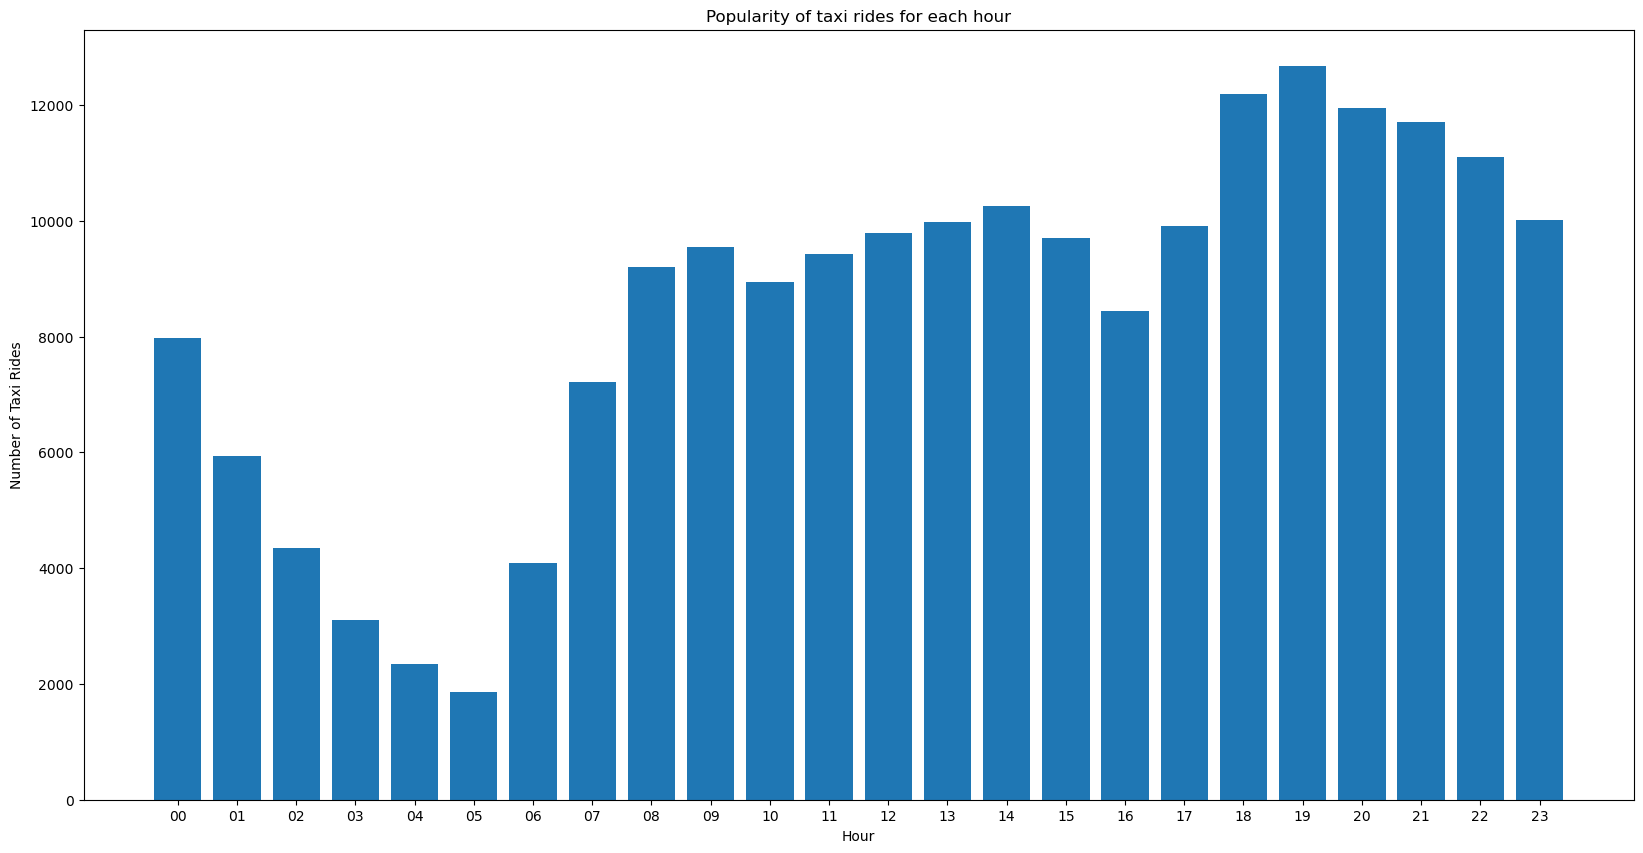

In [69]:
df1 = get_data_for_visual_1()
plot_popularity_hourly(df1)

### Visualization 2

In [70]:
QUERY_taxi = """
    SELECT 
        strftime('%Y-%m', Trip_Pickup_DateTime) AS month, 
        SUM(distance) AS distance
    FROM 
        taxi_trips
    GROUP BY 
        month
             """
QUERY_uber =  """
    SELECT 
        strftime('%Y-%m', Trip_Pickup_DateTime) AS month, 
        SUM(distance) AS distance
    FROM 
        uber_trips
    GROUP BY 
        month
        """

In [74]:
def average_distance_month():
    """
    This function plot the average traveled distance per month, and add the 90% confidence interval for mean
    input: nothing
    output: the graph of average traveled distance per month
    """
    df_taxi = pd.read_sql_query(QUERY_taxi, engine)
    df_uber = pd.read_sql_query(QUERY_uber, engine)
    
    df_taxi['month'] = pd.to_datetime(df_taxi['month'], format='%Y-%m')
    df_uber['month'] = pd.to_datetime(df_uber['month'], format='%Y-%m')
    
    taxi_info = df_taxi.groupby(df_taxi['month'].dt.month)['distance'].agg(['mean','count','sem'])
    uber_info = df_uber.groupby(df_uber['month'].dt.month)['distance'].agg(['mean','count','sem'])
    
    taxi_low, taxi_high = st.t.interval(0.90, taxi_info['count']-1, loc=taxi_info['mean'], scale=taxi_info['sem'])
    uber_low, uber_high = st.t.interval(0.90, uber_info['count']-1, loc=uber_info['mean'], scale=uber_info['sem'])
    
    plt.plot(taxi_info.index, taxi_info['mean'], color='orange', label='Taxi')
    plt.plot(uber_info.index, uber_info['mean'], color='blue', label='Uber')
    
    plt.fill_between(taxi_info.index, taxi_low, taxi_high, color='orange', alpha=0.2)
    plt.fill_between(uber_info.index, uber_low, uber_high, color='blue', alpha=0.2)
    
    plt.xlabel('Month')
    plt.ylabel('Average Distance')
    plt.title('Average Distance Traveled per Month')
    plt.legend()
    
    plt.show()

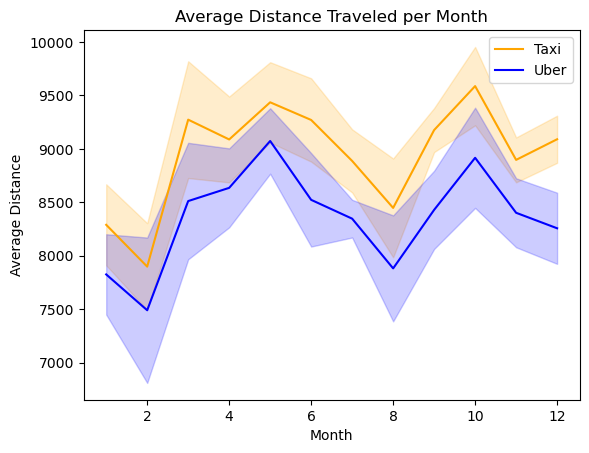

In [75]:
average_distance_month()

### Visualization 3

In [76]:
def get_data_for_visual_3():
    """
    This function gets the dataframe needed for visualization 3
    input: nothing
    output: dataframe, contains day of week and its corresponding trips to each airport
    
    """
    QUERY_LGA = """
    WITH hired_trips AS
    (
    SELECT 
        strftime('%w', Trip_Pickup_DateTime) + 1 AS day_of_week, 
        dropoff_longitude,
        dropoff_latitude
    FROM
        taxi_trips
    WHERE dropoff_longitude < -73.854838 AND dropoff_longitude > -73.891745
        AND dropoff_latitude < 40.778865 AND dropoff_latitude > 40.763589

UNION
    SELECT
        strftime('%w', Trip_Pickup_DateTime) + 1 AS day_of_week, 
        dropoff_longitude,
        dropoff_latitude
    FROM
        uber_trips
    WHERE dropoff_longitude < -73.854838 AND dropoff_longitude > -73.891745
        AND dropoff_latitude < 40.778865 AND dropoff_latitude > 40.763589
    )
    SELECT 
         day_of_week, count(*) AS LGA
    FROM hired_trips
    GROUP BY day_of_week
    ORDER BY day_of_week

"""
    QUERY_JFK = """
    WITH hired_trips AS
    (
    SELECT 
        strftime('%w', Trip_Pickup_DateTime) + 1 AS day_of_week, 
        dropoff_longitude,
        dropoff_latitude
    FROM
        taxi_trips
    WHERE dropoff_longitude < -73.766264 AND dropoff_longitude > -73.795642
        AND dropoff_latitude < 40.651376 AND dropoff_latitude > 40.639263

UNION
    SELECT
        strftime('%w', Trip_Pickup_DateTime) + 1 AS day_of_week, 
        dropoff_longitude,
        dropoff_latitude
    FROM
        uber_trips
    WHERE dropoff_longitude < -73.766264 AND dropoff_longitude > -73.795642
        AND dropoff_latitude < 40.651376 AND dropoff_latitude > 40.639263
    )
    SELECT 
         day_of_week, count(*) AS JFK
    FROM hired_trips
    GROUP BY day_of_week
    ORDER BY day_of_week

"""
    QUERY_EWR = """
    WITH hired_trips AS
    (
    SELECT 
        strftime('%w', Trip_Pickup_DateTime) + 1 AS day_of_week, 
        dropoff_longitude,
        dropoff_latitude
    FROM
        taxi_trips
    WHERE dropoff_longitude < -74.165205 AND dropoff_longitude > -74.194028
        AND dropoff_latitude < 40.699680 AND dropoff_latitude > 40.686794

UNION
    SELECT
        strftime('%w', Trip_Pickup_DateTime) + 1 AS day_of_week, 
        dropoff_longitude,
        dropoff_latitude
    FROM
        uber_trips
    WHERE dropoff_longitude < -74.165205 AND dropoff_longitude > -74.194028
        AND dropoff_latitude < 40.699680 AND dropoff_latitude > 40.686794
    )
    SELECT 
         day_of_week, count(*) AS EWR
    FROM hired_trips
    GROUP BY day_of_week
    ORDER BY day_of_week

"""
    df1 = pd.read_sql_query(QUERY_LGA, engine) 
    df2 = pd.read_sql_query(QUERY_JFK, engine) 
    df3 = pd.read_sql_query(QUERY_EWR, engine) 
    df4 = pd.merge(df1, df2, how = "left", on = ["day_of_week", "day_of_week"])
    df5 = pd.merge(df4, df3, how = "left", on = ["day_of_week", "day_of_week"])
    return df5

In [77]:
def plot_popularity_hourly(dataframe):
    """
    This functions plots the data.
    we can see bar plots with different color representing different airport
    """
    dataframe.plot(x="day_of_week", y=["LGA", "JFK", "EWR"], kind="bar", 
                   title = "Dropoffs for Each Airport in Each Week Day",
                  xlabel = "Week Day", ylabel = "Number of Dropoffs")    

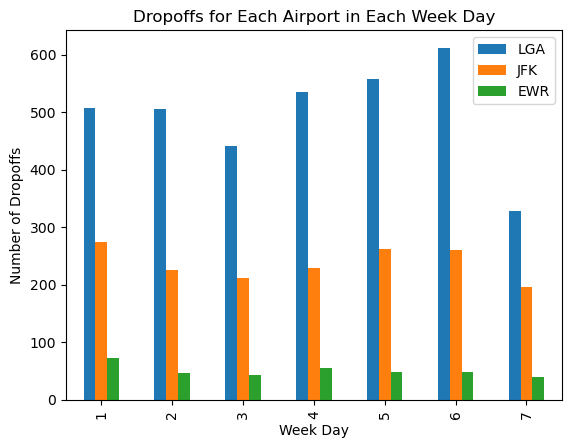

In [78]:
df3 = get_data_for_visual_3()
plot_popularity_hourly(df3)

### Visualization 4

In [79]:
QUERY_trip ="""
    SELECT 
        pickup_longitude, pickup_latitude
    FROM 
        taxi_trips
UNION ALL
    SELECT 
        pickup_longitude, pickup_latitude
    FROM 
        uber_trips
"""

In [82]:
def heatmap_trips():

    """
    This function plot the heatmap of all hired trips over a map of the area.

    """

    df_trip = pd.read_sql_query(QUERY_trip, engine)
    df_trip = gpd.GeoDataFrame(df_trip, geometry=gpd.points_from_xy(df_trip.pickup_longitude, df_trip.pickup_latitude))
        
    zones = taxi_zones_df[['LocationID', 'geometry']].copy()
    df_trip = gpd.GeoDataFrame(df_trip, geometry=gpd.points_from_xy(df_trip.pickup_longitude, df_trip.pickup_latitude))
    result = zones.sjoin(df_trip, how='left')
    result = result.set_index('LocationID')
    result['num'] = result.groupby('LocationID')['geometry'].count()
    result['log_num'] = np.log(result['num'])
    result.plot(column='log_num', cmap='viridis', legend=True, legend_kwds={'label': "Number of Trips in Different Areas"})
    plt.axis('off')
    plt.show()

/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


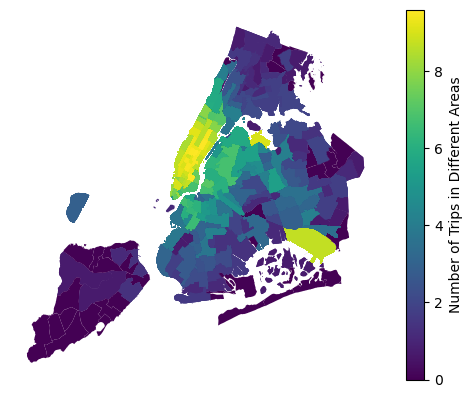

In [83]:
heatmap_trips()

### Visualization 5

In [84]:
def get_data_for_visual_5():
    """
    This functions gets dataframe for visualization 5
    output: dataframe with tip amount and distance
    
    """
    QUERY = """
    SELECT Tip_Amt, distance FROM taxi_trips
    """
    df1 = pd.read_sql_query(QUERY, engine) 
    df1 = df1.sample(2000)
    # only show 2000 data so we can see the trend more clearly
    df1 = df1[df1["Tip_Amt"] < 50]
    # delete outliers with tip amount greater than 50
    df1 = df1[df1["distance"] < 50]
    # delete outliers with distance greater than 50
    return df1

In [85]:
def Tip_Amt_VS_Distance(dataframe):
    """
    This function plot the visualization 5
    we use the scatter plot, in order to let the plot be clear,
    we only use 2000 points
    """
    dataframe.plot(x="distance", y="Tip_Amt", kind="scatter", 
                   title = "Tip Amount Versus Distance for Yellow Taxi Rides",
                  xlabel = "Distance", ylabel = "Tip Amount")   

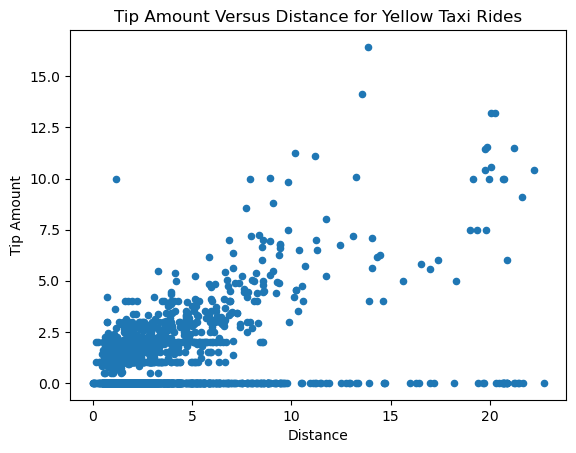

In [86]:
df5 = get_data_for_visual_5()
Tip_Amt_VS_Distance(df5)

### Visualization 6

In [87]:
QUERY_tip ="""
    SELECT strftime('%Y-%m-%d %H', Trip_Pickup_DateTime) AS DATE, Tip_Amt
    FROM taxi_trips
          """ 
QUERY_precipitation ="""
    SELECT strftime('%Y-%m-%d %H', datetime) as DATE, hourly_precipitation
    FROM hourly_weather
          """

In [88]:
def tip_precipitation():
    """
    This function could lead to a scatter graph for yellow taxi rides, 
    which shows the relationship between tip amount and hourly precipitation.
    
    """
    # Load tip and precipitation data into Pandas DataFrames from a database using an engine object
    df_tip = pd.read_sql_query(QUERY_tip, engine)
    df_precipitation =pd.read_sql_query(QUERY_precipitation, engine)
    
    # Merge tip and precipitation data on the 'DATE' column and sample 2000 rows
    df = df_tip.merge(df_precipitation,on = 'DATE').sample(2000)
    
    # Filter rows where hourly precipitation and tip amount are greater than 0
    df = df[(df['hourly_precipitation'] > 0) & (df['Tip_Amt'] > 0)]
    
    # Plot a scatter plot of tip amount vs. hourly precipitation
    df.plot(x="Tip_Amt", y="hourly_precipitation", kind="scatter", 
            title="TipAmt VS. Precipitation for Yellow Taxi rides", 
            xlabel="Tip Amount", ylabel="Hourly Precipitation")

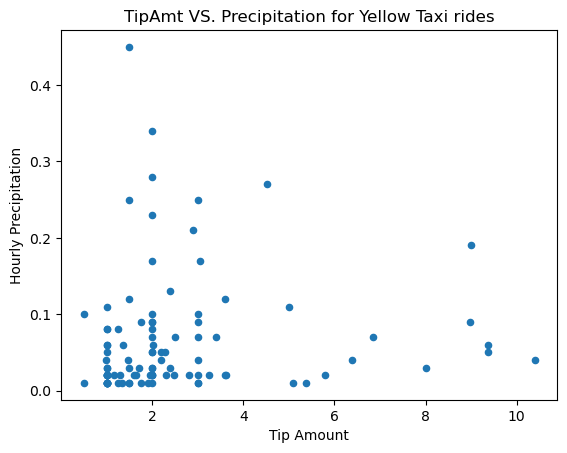

In [89]:
tip_precipitation()